In [1]:
import matplotlib.pyplot as plt
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.model_selection import cross_validate
import tqdm

In [2]:
def get_data():
    file = open('./data/shashlik_61_pulses.txt', 'r')
    data = file.readlines()
    data = np.array([list(map(float, experiment.split())) for experiment in data])
   
    X = data[:, 2:]
    y_baseline = data[:, 1]
    y = data[:, 0]
    
    return X, y

In [3]:
X_origin, y_origin = get_data()

In [4]:
X_origin = np.array([experiment - np.max(experiment) for experiment in X_origin])

In [5]:
def generate_multi_signal(tau, alpha, to_plot=False):
    if tau > X_origin.shape[1]:
        print("Error: value tau = %i is too big" % tau)
    
    first_signal = X_origin[np.random.choice(X_origin.shape[0], 1, replace=False)][0]  
    second_signal = X_origin[np.random.choice(X_origin.shape[0], 1, replace=False)][0]

    second_signal = np.concatenate([second_signal[:tau], second_signal[:-tau]])
    
#     first_signal -= np.max(first_signal)
#     second_signal -= np.max(second_signal)
    
    new_signal = first_signal + second_signal*alpha
    
    if to_plot:
        plt.plot(first_signal)
        plt.plot(second_signal)
        plt.plot(new_signal)
        plt.legend(['First signal', 'Second signal', 'Sum of signals'])
        plt.show()
    
    return new_signal


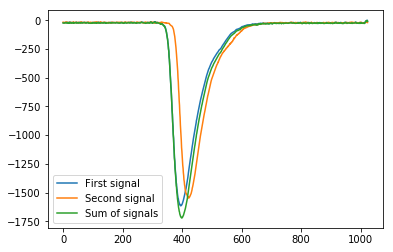

array([-23.688, -23.688, -24.886, ...,  -4.688,  -2.081,  -8.971])

In [6]:
generate_multi_signal(50, 0.1, to_plot=True)

##### Fixate tau and alpha parameters

In [7]:
tau = 50
alpha = 0.1

### Preparing data

In [8]:
##### Hyperaparemeter for dataset size:
data_size = 3000
pos_size = int(data_size/2)
neg_size = data_size - pos_size

In [9]:
idxs = np.random.randint(X_origin.shape[0], size=pos_size)
X_positive = X_origin[idxs]
y_positive = np.ones(pos_size)
print("X positive shape:", X_positive.shape)
print("y positive shape:", y_positive.shape)

X positive shape: (1500, 1024)
y positive shape: (1500,)


In [10]:
X_negative = np.array([generate_multi_signal(tau, alpha) for i in range(neg_size)])
y_negative = np.zeros(neg_size)
print("X negative shape:", X_negative.shape)
print("y negative shape:", y_negative.shape)

X negative shape: (1500, 1024)
y negative shape: (1500,)


In [11]:
from sklearn.utils import shuffle

X = np.concatenate([X_positive, X_negative])
y = np.concatenate([y_positive, y_negative])

X, y = shuffle(X, y)

print("X shape:", X.shape)
print("y shape:", y.shape)

X shape: (3000, 1024)
y shape: (3000,)


### Splitting our data for train and test

In [16]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, stratify=y, test_size=0.3)

print("X_train.shape:", X_train.shape)
print("y_train.shape", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)

X_train.shape: (2100, 1024)
y_train.shape (2100,)
X_test shape: (900, 1024)
y_test shape: (900,)


### Ensemble

In [17]:
from scipy.stats import rankdata
from itertools import cycle
from sklearn.base import BaseEstimator, ClassifierMixin

class ShuffleVoter(BaseEstimator, ClassifierMixin):  
    """
       scikit-learn based voting aggregation ensembling.
       Using bootstrapping creates a set of models, differing only by which data sample they are fed
       """

    def __init__(self, models):
        """
        model - base model ( or a pipeline ) ( unfitted )
        """
        self.models = models
        
    def ensemble_predictions(self, predictions, weights, type_="harmonic"):
        """
        Combines probabilistic class estimates using a variety of strategies.
        Linear, harmonic, geometric and rank averaging are supported at this moment. 
        Insipred by well known Abhishek's kernel on Kaggle 
        model - base model ( or a pipeline ) ( unfitted )
        """
        assert np.isclose(np.sum(weights), 1.0)
        if type_ == "linear":
            res = np.average(predictions, weights=weights, axis=0)
        elif type_ == "harmonic":
            res = np.average([1 / p for p in predictions], weights=weights, axis=0)
            return 1 / res
        elif type_ == "geometric":
            numerator = np.average(
                [np.log(p) for p in predictions], weights=weights, axis=0
            )
            res = np.exp(numerator / sum(weights))
            return res
        elif type_ == "rank":
            res = np.average([rankdata(p) for p in predictions], weights=weights, axis=0)
            return res / (len(res) + 1)
        return res


    def fit( self, X, y, n_boots = 14, test_size = 100 ):
        """
        n_boots - number of bootstrapping iterations ( and respective models built)
        """
        self.clfs  = []
        for i, model in zip(range(n_boots), cycle(self.models)):
            X_tr, X_te, y_tr, y_te = train_test_split( X, y, test_size=test_size, random_state=3521 + i*11)

            pa_clf = model
            pa_clf.fit(X_tr, y_tr)

            self.clfs.append(pa_clf)

    def predict( self, X, ensemble_type = 'rank'):
        # TODO: nonuniform weights
        
        n_boots = len( self.clfs)
        preds = [ clf.predict(X) for clf in self.clfs ]
#         return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)
        return np.round(self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type))

    
    def predict_proba( self, X, ensemble_type = 'rank' ):
        n_boots = len( self.clfs)
        preds = [ clf.predict_proba(X) for clf in self.clfs ]
        return self.ensemble_predictions( preds, np.ones(n_boots)*(1/float(n_boots)), ensemble_type)


### Defining pipelines

In [18]:
import warnings
from sklearn.preprocessing import PolynomialFeatures
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
from sklearn.metrics import f1_score
from sklearn.model_selection import cross_val_score
from sklearn.multiclass import OneVsRestClassifier
from sklearn.svm import LinearSVC
from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.svm import SVC
from sklearn.linear_model import PassiveAggressiveClassifier
from sklearn.model_selection import train_test_split
warnings.filterwarnings('ignore')

In [19]:
def get_pipelines(hyperparams = {'svc_c': 1, 'mlp_max_iter': 1000, 'kn_n': 5, 'pa_c': 1}):
    SVC_pipeline = Pipeline([
                    ('clf', LinearSVC(C=hyperparams['svc_c'])),
                ])


    MLP_pipeline = Pipeline([
                    ('clf', MLPClassifier(max_iter=hyperparams['mlp_max_iter'])),
                ])

    KN_pipeline = Pipeline([
                    ('clf', KNeighborsClassifier(n_neighbors=hyperparams['kn_n'])),
                ])
    
    PA_pipeline = Pipeline([
                ('clf', PassiveAggressiveClassifier(C = hyperparams['pa_c'], max_iter=1000, tol=1e-3)),
            ])

    pipelines = {'svc': SVC_pipeline, 'kn': KN_pipeline, 'pa': PA_pipeline,  'mlp': MLP_pipeline}
    
    return pipelines

In [20]:
pipelines = get_pipelines()

### Pipelines scores:

In [21]:
from sklearn.model_selection import cross_validate
from sklearn.metrics import make_scorer, accuracy_score, precision_score, recall_score, f1_score

In [22]:
for model_name, model in pipelines.items():
    print("Model name:", model_name)
    
    scoring = {'accuracy' : make_scorer(accuracy_score), 
           'precision' : make_scorer(precision_score),
           'recall' : make_scorer(recall_score), 
           'f1_score' : make_scorer(f1_score)}
    
    scores = cross_validate(model, X, y, scoring=scoring, cv=10)
    for score in scoring.keys():
        print(score, "%0.5f (+/- %0.5f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))
    print('------------------------------')

Model name: svc
accuracy 0.89133 (+/- 0.17543)
precision 0.91317 (+/- 0.09364)
recall 0.87667 (+/- 0.41975)
f1_score 0.87210 (+/- 0.29263)
------------------------------
Model name: kn
accuracy 0.99700 (+/- 0.00629)
precision 1.00000 (+/- 0.00000)
recall 0.99400 (+/- 0.01258)
f1_score 0.99698 (+/- 0.00635)
------------------------------
Model name: pa
accuracy 0.91633 (+/- 0.03062)
precision 0.87911 (+/- 0.05839)
recall 0.96733 (+/- 0.04107)
f1_score 0.92057 (+/- 0.02639)
------------------------------
Model name: mlp
accuracy 0.93667 (+/- 0.06498)
precision 0.95263 (+/- 0.06996)
recall 0.92133 (+/- 0.13725)
f1_score 0.93462 (+/- 0.07265)
------------------------------


### Ensemble score

In [23]:
my_shuffle_voter = ShuffleVoter(list(pipelines.values()))

scoring = {'accuracy' : make_scorer(accuracy_score), 
       'precision' : make_scorer(precision_score),
       'recall' : make_scorer(recall_score), 
       'f1_score' : make_scorer(f1_score)}

scores = cross_validate(my_shuffle_voter, X, y, scoring=scoring, cv=5)
for score in scoring.keys():
    print(score, "%0.9f (+/- %0.9f)" % (scores["test_" + score].mean(), scores["test_" + score].std() * 2))

accuracy 0.968333333 (+/- 0.050376361)
precision 0.955597276 (+/- 0.093021674)
recall 0.985333333 (+/- 0.016110728)
f1_score 0.969512916 (+/- 0.045891355)
